**서포트벡터머신** : 머신러닝 기법의 하나로 패턴인식,이진분류를 위한 비확률적 지도학습 모델
    (주로 회귀와 분류문제 해결에 사용)
- 장점
    - 회귀와 분류에 모두 적용할 수 있음.
    - 라벨을 직접 추정하기때문에 조건부확률로 예측하는 모형에 비해 예측력이 높음.
    - 과적합의 가능성이 낮음.

- 단점
    - 데이터 스케일링에 민감함.
    - 고차원으로 갈수록 여러 연산이 필요해서 학습속도가 느림.
    - 다양한 하이퍼파라미터(커널,C,gamma)값을 여러 번 조합해 최적의 모델을 구해야함.
    - 모형이 복잡해 결과에 대한 설명이 어려움.
    

**중요 하이퍼 파라미터**
* Kernel : 주어진 데이터를 공간 상에서 분류하는 함수를 지정(linear,poly,RBF가 있음, 고차원 데이터는 선형분류로는 예측력이 매우 낮음)
* C : 서포트벡터와 결정경계 사이의 마진(거리)을 설정(C가 클수록 마진이 좁아짐,하드마진)
* gamma : 비선형 커널에서 결정경계의 곡률을 설정(높을수록 곡률이 큼,오차를 적게 허용)

C와 gamma를 높게 설정할수록 오류를 덜 허용하여 과적합될 수도 있음

## 전처리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder # for encoding
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler #for standardization
from sklearn.model_selection import train_test_split
import time

In [2]:
def preprocessing(df_scaling, scaled_form = 'MinMaxScaler()'):
    # 불필요한 컬럼 제거
    if 'ID' in df_scaling:
        df_scaling = df_scaling.drop("ID", axis = 1)
        if len(df_scaling.columns) == 1:
            return df_scaling
        
        def func(x):
            if x < 1.0 :
                return 1
            elif x < 1.6 :
                return 2
            elif x <= 2.0 :
                return 3
            else : 
                return 4
        df_scaling['eyesight(left)'] = df_scaling['eyesight(left)'].apply(lambda x:func(x))    
        df_scaling['eyesight(right)'] = df_scaling['eyesight(right)'].apply(lambda x:func(x))
        
        # Urine protein 범주화
        x = df_scaling['Urine protein']
        for i in range(len(x)):
            if(x[i] == 1.0):
                x[i] = 0
            elif(x[i] == 2.0):
                x[i] = 1
            else:
                x[i] = 2
        df_scaling['Urine protein'] = x
        
        df_scaling = df_scaling.drop('oral', axis = 1) 
        # 범주형 피처 레이블 인코딩 
        cate_features = df_scaling[['gender','tartar']]

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["gender"])
        df_scaling["gender"] = lbe.fit_transform(df_scaling["gender"])

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["tartar"])
        df_scaling["tartar"] = lbe.fit_transform(df_scaling["tartar"])
        # hearing 피처 1, 2 => 1, 0으로 변환
        df_scaling['hearing(left)'] = df_scaling['hearing(left)'].apply(lambda x: x-2 if x ==2.0 else x )
        df_scaling['hearing(right)'] = df_scaling['hearing(right)'].apply(lambda x: x-2 if x ==2.0 else x )
        
        # BMI 지수 계산
        # bmi = kg/m^2
        #df_scaling['bmi'] = df_scaling['weight(kg)']/((df_scaling['height(cm)']*0.01)**2)
        # wwi(비만 지수) 지수 계산
        #df_scaling['wwi'] = df_scaling['waist(cm)']/(df_scaling['weight(kg)'].apply(np.sqrt))
        return df_scaling

In [3]:
def scaling(train_data, test_data, scaled_form = 'MinMaxScaler()'):
    # 형태 별 특성 구분
    train_data = preprocessing(train_data)
    test_data = preprocessing(test_data)
    tr_cate_features = train_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries']]
    tr_scaled_features = train_data.drop(tr_cate_features.columns, axis=1)
    
    ts_cate_features = test_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries']]
    ts_scaled_features = test_data.drop(ts_cate_features.columns, axis=1)
    
    if scaled_form == 'StandardScaler()':
        # Standard scaler
        scaler = StandardScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        train_std_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_std_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_std_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_std_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_std_scaled, test_std_scaled
    
    elif scaled_form == 'RobustScaler()':
        # Robust scaler
        scaler = RobustScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_robust_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_robust_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_robust_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_robust_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_robust_scaled, test_robust_scaled

    
    elif scaled_form == 'logScaler()' :
        tr_scaled = np.log1p(tr_scaled_features)
        ts_scaled = np.log1p(ts_scaled_features)
         # 데이터 프레임 형태로 변환
        train_log_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_log_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_log_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_log_scaled[ts_cate_features.columns] = ts_cate_features 
        
        return train_log_scaled, test_log_scaled
        
    else:
        # MinMax scaler
        scaler = MinMaxScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_mmx_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_mmx_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_mmx_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_mmx_scaled[ts_cate_features.columns] = ts_cate_features

        return train_mmx_scaled, test_mmx_scaled

In [4]:
# competition_format
x_train = pd.read_csv('./data/Smoking_raw/competition_format/x_train.csv')
x_test = pd.read_csv('./data/Smoking_raw/competition_format/x_test.csv')
y_train = pd.read_csv('./data/Smoking_raw/competition_format/y_train.csv')
y_test = pd.read_csv('./data/Smoking_raw/competition_format/y_test.csv')

In [59]:
x_train=preprocessing(x_train)
x_train

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1


,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
0,0,40,155,60,81.3,2,2,1.0,1.0,114.0,...,73.0,126.0,12.9,0.0,0.7,18.0,19.0,27.0,0.0,1
1,0,40,160,60,81.0,1,1,1.0,1.0,119.0,...,42.0,127.0,12.7,0.0,0.6,22.0,19.0,18.0,0.0,1
2,1,55,170,60,80.0,1,1,1.0,1.0,138.0,...,55.0,151.0,15.8,0.0,1.0,21.0,16.0,22.0,0.0,0
3,1,40,165,70,88.0,2,2,1.0,1.0,100.0,...,45.0,226.0,14.7,0.0,1.0,19.0,26.0,18.0,0.0,1
4,0,40,155,60,86.0,2,2,1.0,1.0,120.0,...,62.0,107.0,12.5,0.0,0.6,16.0,14.0,22.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,1,50,170,65,88.0,2,2,1.0,1.0,148.0,...,40.0,108.0,15.2,0.0,1.0,45.0,49.0,51.0,0.0,1
44549,1,35,175,70,84.0,1,1,1.0,1.0,105.0,...,57.0,118.0,15.2,0.0,0.9,20.0,14.0,16.0,0.0,1
44550,1,35,175,70,70.9,2,2,1.0,1.0,116.0,...,41.0,92.0,13.4,0.0,1.0,18.0,19.0,10.0,0.0,1
44551,1,50,165,90,106.8,1,1,1.0,1.0,122.0,...,47.0,104.0,14.5,0.0,0.9,30.0,49.0,40.0,0.0,1


In [58]:
x_train

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,Y,0.0,Y
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,Y,0.0,Y
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,Y,0.0,N
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,Y,0.0,Y
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,Y,0.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,55686,M,50,170,65,88.0,1.2,1.2,1.0,1.0,...,108.0,15.2,1.0,1.0,45.0,49.0,51.0,Y,0.0,Y
44549,55687,M,35,175,70,84.0,0.6,0.7,1.0,1.0,...,118.0,15.2,1.0,0.9,20.0,14.0,16.0,Y,0.0,Y
44550,55688,M,35,175,70,70.9,1.5,1.5,1.0,1.0,...,92.0,13.4,1.0,1.0,18.0,19.0,10.0,Y,0.0,Y
44551,55689,M,50,165,90,106.8,0.8,0.5,1.0,1.0,...,104.0,14.5,1.0,0.9,30.0,49.0,40.0,Y,0.0,Y


In [346]:
y_train=preprocessing(y_train)
y_train

,smoking
0,0
1,0
2,1
3,0
4,0
...,...
44548,0
44549,0
44550,0
44551,1


In [60]:
x_test=preprocessing(x_test)
x_test.head()

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1


,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
0,1,80,160,65,91.0,1,1,1.0,1.0,120.0,...,61.0,94.0,14.5,0.0,1.0,29.0,19.0,39.0,0.0,0
1,1,30,165,90,98.0,2,2,1.0,1.0,136.0,...,58.0,165.0,15.6,0.0,0.9,20.0,37.0,34.0,0.0,0
2,1,40,170,75,81.0,2,2,1.0,1.0,138.0,...,37.0,98.0,16.4,0.0,0.7,25.0,32.0,73.0,0.0,0
3,1,35,175,70,80.0,2,2,1.0,1.0,160.0,...,53.0,160.0,15.3,0.0,0.7,30.0,55.0,50.0,0.0,0
4,1,35,160,75,93.0,2,2,1.0,1.0,125.0,...,58.0,132.0,14.7,0.0,1.1,35.0,58.0,56.0,0.0,0


In [348]:
y_test=preprocessing(y_test)
y_test.head()

,smoking
0,1
1,0
2,1
3,0
4,0


In [5]:
scaled = scaling(x_train, x_test,scaled_form='StandardScaler()')

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1
C:\Users\JungHun

In [6]:
x_train_s = pd.DataFrame(scaled[0])
x_test_s = pd.DataFrame(scaled[1])
y_train_s = preprocessing(y_train)
y_test_s = preprocessing(y_test)

In [7]:
x_train_s.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,-0.348302,-1.049853,-0.458800,-0.083771,0.764262,0.770830,-0.550024,-0.313914,-0.255217,0.494320,...,-0.228172,-0.823115,-0.430331,-0.254602,-0.257586,0,1,1.0,1.0,0.0
1,-0.348302,-0.506284,-0.458800,-0.116105,-1.182462,-1.178472,-0.184756,-0.623346,1.471806,-0.137158,...,-0.228172,-1.265418,-0.220763,-0.254602,-0.435020,0,1,1.0,1.0,0.0
2,0.892501,0.580854,-0.458800,-0.223885,-1.182462,-1.178472,1.203261,1.026958,-0.495081,1.235620,...,-0.228172,0.503794,-0.273155,-0.349076,-0.356161,1,0,1.0,1.0,0.0
3,-0.348302,0.037285,0.321016,0.638353,0.764262,0.770830,-1.572773,-1.654787,-0.159271,3.432064,...,-0.228172,0.503794,-0.377939,-0.034160,-0.435020,1,1,1.0,1.0,0.0
4,-0.348302,-1.049853,-0.458800,0.422793,0.764262,0.770830,-0.111703,-0.210770,-0.926837,-0.356803,...,-0.228172,-1.265418,-0.535115,-0.412060,-0.356161,0,0,1.0,1.0,0.0


In [8]:
x_train_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44553 entries, 0 to 44552
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  44553 non-null  float64
 1   height(cm)           44553 non-null  float64
 2   weight(kg)           44553 non-null  float64
 3   waist(cm)            44553 non-null  float64
 4   eyesight(left)       44553 non-null  float64
 5   eyesight(right)      44553 non-null  float64
 6   systolic             44553 non-null  float64
 7   relaxation           44553 non-null  float64
 8   fasting blood sugar  44553 non-null  float64
 9   Cholesterol          44553 non-null  float64
 10  triglyceride         44553 non-null  float64
 11  HDL                  44553 non-null  float64
 12  LDL                  44553 non-null  float64
 13  hemoglobin           44553 non-null  float64
 14  Urine protein        44553 non-null  float64
 15  serum creatinine     44553 non-null 

In [9]:
x_test_s.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,2.960507,-0.506284,-0.068892,0.961692,-1.182462,-1.178472,-0.111703,0.408094,0.608295,-0.768636,...,-0.228172,0.503794,0.145981,-0.254602,-0.021007,1,0,1.0,1.0,0.0
1,-1.175504,0.037285,1.880649,1.716150,0.764262,0.770830,1.057153,0.717526,-0.159271,1.263075,...,-0.228172,0.061491,-0.325547,0.312248,-0.119581,1,0,1.0,1.0,0.0
2,-0.348302,0.580854,0.710924,-0.116105,0.764262,0.770830,1.203261,1.026958,-0.351163,-0.933369,...,-0.228172,-0.823115,-0.063587,0.154790,0.649301,1,0,1.0,1.0,0.0
3,-0.761903,1.124422,0.321016,-0.223885,0.764262,0.770830,2.810438,2.470975,0.032620,1.400353,...,-0.228172,-0.823115,0.198373,0.879098,0.195858,1,0,1.0,1.0,0.0
4,-0.761903,-0.506284,0.710924,1.177251,0.764262,0.770830,0.253565,0.408094,0.848159,0.439408,...,-0.228172,0.946097,0.460333,0.973573,0.314147,1,0,1.0,1.0,0.0


In [247]:
SVM1=SVC()

In [ ]:
SVM1.fit(x_train_s,y_train_s)

In [343]:
SVM_basic=SVC()

In [347]:
SVM_basic.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [349]:
basic=SVM_basic.predict(x_test)

In [350]:
exba=score(y_test,basic)

# 기본모델의 성능

In [351]:
exba

(0.7358829338360715,
 0.6751131221719457,
 0.5454545454545454,
 0.6033971420868158,
 0.6961923096800868)

## 모델링

### Standard Scaler

In [62]:
best1=GridSearchCV(SVM1,param_grid=param_svm,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)

In [63]:
best1.fit(x_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packa

ValueError: y should be a 1d array, got an array of shape (44553, 2) instead.

In [ ]:
print('best params',best1.best_params_)
print('best score',best1.best_score_)

In [10]:
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve,precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [11]:
SVM=SVC()

In [58]:
SVM

SVC()

In [12]:
param_svm = { 'C' : [0.1,0.5,1,3,5,10,50,100],
              'gamma': ['auto','scale'],
            'kernel':['rbf']}

In [13]:
param_svm

{'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
 'gamma': ['auto', 'scale'],
 'kernel': ['rbf']}

In [16]:
best=GridSearchCV(SVM,param_grid=param_svm,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)


In [17]:
best

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [18]:
best.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [19]:
print('best params',best.best_params_)
print('best score',best.best_score_)


best params {'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}
best score 0.7567167194128341


In [183]:
result_s=pd.DataFrame(best.cv_results_)

In [234]:
result_s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,227.156228,2.493226,102.119170,0.995450,0.1,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.755639,0.746616,0.749377,0.750544,0.003775,10
1,227.498852,1.836345,102.670635,0.599577,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.754629,0.746751,0.749579,0.750320,0.003259,11
2,192.528273,37.098657,93.008009,2.635678,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.758063,0.755841,0.753148,0.755684,0.002010,6
3,143.065544,0.118263,95.192011,0.558753,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.757929,0.755909,0.753417,0.755752,0.001845,5
4,146.207080,0.393518,94.911103,0.743841,1,auto,rbf,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.758602,0.757188,0.753821,0.756537,0.002005,2
5,142.095685,2.593638,87.359202,6.480388,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.758939,0.756447,0.753283,0.756223,0.002315,4
6,177.092474,0.912569,90.676989,0.296500,3,auto,rbf,"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}",0.760016,0.757255,0.752879,0.756717,0.002939,1
7,191.372249,7.364057,91.457445,0.446122,3,scale,rbf,"{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}",0.758871,0.756380,0.753619,0.756290,0.002145,3
8,222.372770,12.766803,83.361159,4.423889,5,auto,rbf,"{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}",0.757727,0.755033,0.752205,0.754988,0.002254,7
9,236.524540,13.436209,91.934154,1.371980,5,scale,rbf,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.758333,0.754023,0.751263,0.754540,0.002909,8


In [192]:
result_s.iloc[result_s['rank_test_score'].idxmin(),:]['params']

{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}

## linear 커널

In [50]:
SVM_linear=SVC(kernel='linear')

In [51]:
param_C = { 'C' : [0.1,0.5,1,3,5,10,50,100]}

In [52]:
best_linear=GridSearchCV(SVM_linear,param_grid=param_C,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)

In [53]:
best_linear.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100]},
             scoring='accuracy', verbose=2)

In [54]:
print('best params',best_linear.best_params_)
print('best score',best_linear.best_score_)


best params {'C': 0.1}
best score 0.7427333737346532


## min-max scaling

In [25]:
scaled_m = scaling(x_train, x_test)

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1
C:\Users\JungHun

In [26]:
x_train_m = pd.DataFrame(scaled_m[0])
x_test_m = pd.DataFrame(scaled_m[1])
y_train_m = preprocessing(y_train)
y_test_m = preprocessing(y_test)

In [27]:
x_train_m.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,0.307692,0.416667,0.285714,0.388462,0.333333,0.333333,0.254438,0.311321,0.104575,0.410256,...,0.0,0.052174,0.009195,0.006179,0.026052,0,1,1.0,1.0,0.0
1,0.307692,0.500000,0.285714,0.384615,0.000000,0.000000,0.284024,0.283019,0.183007,0.351282,...,0.0,0.043478,0.012261,0.006179,0.017034,0,1,1.0,1.0,0.0
2,0.538462,0.666667,0.285714,0.371795,0.000000,0.000000,0.396450,0.433962,0.093682,0.479487,...,0.0,0.078261,0.011494,0.005149,0.021042,1,0,1.0,1.0,0.0
3,0.307692,0.583333,0.380952,0.474359,0.333333,0.333333,0.171598,0.188679,0.108932,0.684615,...,0.0,0.078261,0.009962,0.008582,0.017034,1,1,1.0,1.0,0.0
4,0.307692,0.416667,0.285714,0.448718,0.333333,0.333333,0.289941,0.320755,0.074074,0.330769,...,0.0,0.043478,0.007663,0.004463,0.021042,0,0,1.0,1.0,0.0


In [28]:
x_test_m.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,0.923077,0.500000,0.333333,0.512821,0.000000,0.000000,0.289941,0.377358,0.143791,0.292308,...,0.0,0.078261,0.017625,0.006179,0.038076,1,0,1.0,1.0,0.0
1,0.153846,0.583333,0.571429,0.602564,0.333333,0.333333,0.384615,0.405660,0.108932,0.482051,...,0.0,0.069565,0.010728,0.012358,0.033066,1,0,1.0,1.0,0.0
2,0.307692,0.666667,0.428571,0.384615,0.333333,0.333333,0.396450,0.433962,0.100218,0.276923,...,0.0,0.052174,0.014559,0.010642,0.072144,1,0,1.0,1.0,0.0
3,0.230769,0.750000,0.380952,0.371795,0.333333,0.333333,0.526627,0.566038,0.117647,0.494872,...,0.0,0.052174,0.018391,0.018538,0.049098,1,0,1.0,1.0,0.0
4,0.230769,0.500000,0.428571,0.538462,0.333333,0.333333,0.319527,0.377358,0.154684,0.405128,...,0.0,0.086957,0.022222,0.019567,0.055110,1,0,1.0,1.0,0.0


In [38]:
best_m=GridSearchCV(SVM,param_grid=param_svm,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)


In [39]:
best_m

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [40]:
best_m.fit(x_train_m,y_train_m)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [41]:
print('best params',best_m.best_params_)
print('best score',best_m.best_score_)


best params {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
best score 0.75029739860391


In [193]:
result_m=pd.DataFrame(best_m.cv_results_)

In [197]:
result_m.iloc[result_m['rank_test_score'].idxmin(),:]['params']

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

## robust scaling

In [29]:
scaled_r = scaling(x_train, x_test,scaled_form='RobustScaler()')

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1
C:\Users\JungHun

In [30]:
x_train_r = pd.DataFrame(scaled_r[0])
x_test_r = pd.DataFrame(scaled_r[1])
y_train_r = preprocessing(y_train)
y_test_r = preprocessing(y_test)

In [32]:
x_train_r.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,0.0,-1.0,-0.25,-0.058333,0.0,0.0,-0.333333,-0.250000,-0.133333,0.416667,...,0.0,-1.0,-0.5,-0.1250,0.037037,0,1,1.0,1.0,0.0
1,0.0,-0.5,-0.25,-0.083333,-1.0,-1.0,-0.055556,-0.500000,2.266667,-0.062500,...,0.0,-1.5,-0.1,-0.1250,-0.296296,0,1,1.0,1.0,0.0
2,1.0,0.5,-0.25,-0.166667,-1.0,-1.0,1.000000,0.833333,-0.466667,0.979167,...,0.0,0.5,-0.2,-0.3125,-0.148148,1,0,1.0,1.0,0.0
3,0.0,0.0,0.25,0.500000,0.0,0.0,-1.111111,-1.333333,0.000000,2.645833,...,0.0,0.5,-0.4,0.3125,-0.296296,1,1,1.0,1.0,0.0
4,0.0,-1.0,-0.25,0.333333,0.0,0.0,0.000000,-0.166667,-1.066667,-0.229167,...,0.0,-1.5,-0.7,-0.4375,-0.148148,0,0,1.0,1.0,0.0


In [31]:
x_test_r.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,2.666667,-0.5,0.00,0.750000,-1.0,-1.0,0.000000,0.333333,1.066667,-0.541667,...,0.0,0.5,0.6,-0.1250,0.481481,1,0,1.0,1.0,0.0
1,-0.666667,0.0,1.25,1.333333,0.0,0.0,0.888889,0.583333,0.000000,1.000000,...,0.0,0.0,-0.3,1.0000,0.296296,1,0,1.0,1.0,0.0
2,0.000000,0.5,0.50,-0.083333,0.0,0.0,1.000000,0.833333,-0.266667,-0.666667,...,0.0,-1.0,0.2,0.6875,1.740741,1,0,1.0,1.0,0.0
3,-0.333333,1.0,0.25,-0.166667,0.0,0.0,2.222222,2.000000,0.266667,1.104167,...,0.0,-1.0,0.7,2.1250,0.888889,1,0,1.0,1.0,0.0
4,-0.333333,-0.5,0.50,0.916667,0.0,0.0,0.277778,0.333333,1.400000,0.375000,...,0.0,1.0,1.2,2.3125,1.111111,1,0,1.0,1.0,0.0


In [42]:
best_r=GridSearchCV(SVM,param_grid=param_svm,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)


In [43]:
best_r

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [196]:
result_s['rank_test_score'].idxmin()

6

In [44]:
best_r.fit(x_train_r,y_train_r)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [45]:
print('best params',best_r.best_params_)
print('best score',best_r.best_score_)


best params {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
best score 0.7569187260117163


In [66]:
pd.DataFrame(best_r.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,145.172292,1.173750,102.182453,0.126393,0.1,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.751869,0.748502,0.747290,0.749220,0.001937,15
1,146.229880,0.857021,106.733608,0.168702,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.750455,0.745943,0.742442,0.746280,0.003280,16
2,140.716941,2.273266,95.779630,2.736408,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.755168,0.748704,0.750118,0.751330,0.002775,12
3,140.240373,0.655926,98.533626,0.959387,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.754697,0.747896,0.748165,0.750253,0.003144,14
4,139.418726,0.961915,93.528177,0.682101,1,auto,rbf,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.756649,0.750859,0.751263,0.752923,0.002640,8
5,139.182468,1.591506,94.833895,3.105612,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.754899,0.747357,0.749242,0.750499,0.003205,13
6,137.279872,1.726366,92.286244,0.569775,3,auto,rbf,"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}",0.756851,0.752677,0.751667,0.753732,0.002244,7
7,137.034219,1.046509,95.020466,1.230569,3,scale,rbf,"{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}",0.755168,0.749444,0.750253,0.751622,0.002529,11
8,135.950878,1.948096,89.465482,1.153077,5,auto,rbf,"{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}",0.756784,0.754091,0.751397,0.754091,0.002199,5
9,138.719447,1.385735,92.270120,0.244781,5,scale,rbf,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.755774,0.750589,0.751061,0.752475,0.002341,10


## log scaling

In [33]:
scaled_l = scaling(x_train, x_test,scaled_form='logScaler()')

C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\JungHun.DESKTOP-JRGUSS9\AppData\Local\Temp\ipykernel_13756\2673988547.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1
C:\Users\JungHun

In [35]:
x_train_l = pd.DataFrame(scaled_l[0])
x_test_l = pd.DataFrame(scaled_l[1])
y_train_l = preprocessing(y_train)
y_test_l = preprocessing(y_test)

In [36]:
x_train_l.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,3.713572,5.049856,4.110874,4.410371,1.098612,1.098612,4.744932,4.304065,4.553877,5.375278,...,0.0,0.530628,2.944439,2.995732,3.332205,0,1,1.0,1.0,0.0
1,3.713572,5.081404,4.110874,4.406719,0.693147,0.693147,4.787492,4.262680,4.875197,5.262690,...,0.0,0.470004,3.135494,2.995732,2.944439,0,1,1.0,1.0,0.0
2,4.025352,5.141664,4.110874,4.394449,0.693147,0.693147,4.934474,4.465908,4.499810,5.493061,...,0.0,0.693147,3.091042,2.833213,3.135494,1,0,1.0,1.0,0.0
3,3.713572,5.111988,4.262680,4.488636,1.098612,1.098612,4.615121,4.110874,4.574711,5.777652,...,0.0,0.693147,2.995732,3.295837,2.944439,1,1,1.0,1.0,0.0
4,3.713572,5.049856,4.110874,4.465908,1.098612,1.098612,4.795791,4.317488,4.394449,5.220356,...,0.0,0.470004,2.833213,2.708050,3.135494,0,0,1.0,1.0,0.0


In [37]:
x_test_l.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,4.394449,5.081404,4.189655,4.521789,0.693147,0.693147,4.795791,4.394449,4.727388,5.135798,...,0.0,0.693147,3.401197,2.995732,3.688879,1,0,1.0,1.0,0.0
1,3.433987,5.111988,4.510860,4.595120,1.098612,1.098612,4.919981,4.430817,4.574711,5.497168,...,0.0,0.641854,3.044522,3.637586,3.555348,1,0,1.0,1.0,0.0
2,3.713572,5.141664,4.330733,4.406719,1.098612,1.098612,4.934474,4.465908,4.532599,5.099866,...,0.0,0.530628,3.258097,3.496508,4.304065,1,0,1.0,1.0,0.0
3,3.583519,5.170484,4.262680,4.394449,1.098612,1.098612,5.081404,4.615121,4.615121,5.517453,...,0.0,0.530628,3.433987,4.025352,3.931826,1,0,1.0,1.0,0.0
4,3.583519,5.081404,4.330733,4.543295,1.098612,1.098612,4.836282,4.394449,4.770685,5.365976,...,0.0,0.741937,3.583519,4.077537,4.043051,1,0,1.0,1.0,0.0


In [ ]:
ㅠ

In [46]:
best_l=GridSearchCV(SVM,param_grid=param_svm,cv=3,scoring ='accuracy',n_jobs=-1,verbose=2)


In [47]:
best_l

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [48]:
best_l.fit(x_train_l,y_train_l)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [49]:
print('best params',best_l.best_params_)
print('best score',best_l.best_score_)


best params {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
best score 0.7569187260117163


In [198]:
result_l=pd.DataFrame(best_l.cv_results_)

In [236]:
result_l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,146.045576,0.569419,103.623770,1.085486,0.1,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.751869,0.748502,0.747290,0.749220,0.001937,15
1,147.287280,0.640771,107.983843,0.351373,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.750455,0.745943,0.742442,0.746280,0.003280,16
2,140.921626,0.720993,96.456156,3.423980,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.755168,0.748704,0.750118,0.751330,0.002775,12
3,140.484804,1.260662,99.346314,1.800195,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.754697,0.747896,0.748165,0.750253,0.003144,14
4,140.706334,0.851953,96.134151,0.137460,1,auto,rbf,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.756649,0.750859,0.751263,0.752923,0.002640,8
5,139.688253,2.580773,97.563844,1.183427,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.754899,0.747357,0.749242,0.750499,0.003205,13
6,141.658981,1.173627,98.388718,1.830440,3,auto,rbf,"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}",0.756851,0.752677,0.751667,0.753732,0.002244,7
7,141.865918,1.549708,100.547140,0.782403,3,scale,rbf,"{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}",0.755168,0.749444,0.750253,0.751622,0.002529,11
8,149.485915,2.169668,94.304663,2.665155,5,auto,rbf,"{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}",0.756784,0.754091,0.751397,0.754091,0.002199,5
9,152.401261,2.419796,99.560334,1.029794,5,scale,rbf,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.755774,0.750589,0.751061,0.752475,0.002341,10


In [280]:
best.best_estimator_

SVC(C=3, gamma='auto')

In [199]:
result_l.iloc[result_l['rank_test_score'].idxmin(),:]['params']

{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}

## scaling 별 비교

In [ ]:
# standard,min-max,robust,log
[best.best_score_,best_m.best_score_,best_l.best_score_]

In [91]:
def cm(model,x,y):
    start = time.time()
    pred=model.predict(x)
    cm=confusion_matrix(y,pred)
    print("time :", time.time() - start)
    return pred,cm_s

In [113]:
def score(y_test,pred):
    acc=accuracy_score(y_test,pred)
    pre=precision_score(y_test , pred)
    rec=recall_score(y_test , pred)
    f1=f1_score(y_test,pred)
    auc=roc_auc_score(y_test, pred)
    return acc,pre,rec,f1,auc

In [ ]:
score()

## 학습된 베스트 하이퍼 파라미터로  예측

#### standard

In [69]:
standard=best.best_estimator_

In [281]:
standard

SVC(C=3, gamma='auto')

In [75]:
start = time.time()

pred_s=standard.predict(x_train_s)
cm_s=confusion_matrix(y_train_s, pred_s)
print(cm_s)

start = time.time()

[[22955  5246]
 [ 3947 12405]]
time : 175.72230863571167


In [160]:
start=time.time()
acc=accuracy_score(y_train_s,pred_s)
pre=precision_score(y_train_s , pred_s)
rec=recall_score(y_train_s , pred_s)
f1=f1_score(y_train_s,pred_s)
auc=roc_auc_score(y_train_s, pred_s)
print(time.time()-start)

0.06908965110778809


In [167]:
print('정확도 : {:.3f}'.format(acc))
# 정밀도
print('정밀도 : {:.3f}'.format(pre))
# 재현율
print('재현율 : {:.3f}'.format(rec))
# f1_score
print('F1_score : {:.3f}'.format(f1))
# AUC score 
print('ROC_AUC_score : {:.3f}'.format(auc))

정확도 : 0.794
정밀도 : 0.703
재현율 : 0.759
F1_score : 0.730
ROC_AUC_score : 0.786


In [271]:
standard.support_vectors_

array([[-0.34830205,  0.03728472,  0.32101591, ...,  1.        ,
         1.        ,  0.        ],
       [-1.17550435,  1.66799118,  0.71092409, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.06529909,  0.03728472,  1.88064863, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.30610253, -0.5062841 , -0.84870863, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.30610253,  0.03728472,  0.32101591, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.47890024,  0.03728472,  1.88064863, ...,  1.        ,
         1.        ,  0.        ]])

In [76]:
start = time.time()

pred_st=standard.predict(x_test_s)
cm_st=confusion_matrix( y_test_s, pred_st)
print(cm_st)
print("time :", time.time() - start)

[[5723 1313]
 [1002 3101]]
time : 48.28132486343384


In [82]:
start=time.time()
acc_st=accuracy_score(y_test_s,pred_st)
pre_st=precision_score(y_test_s , pred_st)
rec_st=recall_score(y_test_s , pred_st)
f1_st=f1_score(y_test_s,pred_st)
auc_st=roc_auc_score(y_test_s, pred_st)
print(time.time()-start)

0.023611068725585938


In [83]:
print('정확도 : {:.3f}'.format(acc_st))
# 정밀도
print('정밀도 : {:.3f}'.format(pre_st))
# 재현율
print('재현율 : {:.3f}'.format(rec_st))
# f1_score
print('F1_score : {:.3f}'.format(f1_st))
# AUC score 
print('ROC_AUC_score : {:.3f}'.format(auc_st))

정확도 : 0.792
정밀도 : 0.703
재현율 : 0.756
F1_score : 0.728
ROC_AUC_score : 0.785


#### minmax

In [70]:
minmax=best_m.best_estimator_

In [259]:
minmax

SVC(C=50)

In [92]:
pred_m,cm_m=cm(minmax,x_train_m,y_train_m)

time : 205.01099753379822


In [112]:
pred_m

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [96]:
cm_m

array([[22955,  5246],
       [ 3947, 12405]], dtype=int64)

In [93]:
score(y_train_m,pred_m)

[0.7643480798150517,
 0.6582833035859159,
 0.7443126223091977,
 0.6986596251542722,
 0.7601390068036894]

In [ ]:
pred_s=standard.predict(x_train)

In [103]:
pred_mt,cm_mt=cm(minmax,x_test_m,y_test_m)

time : 28.274210453033447


In [108]:
best

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10, 50, 100],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [109]:
cm_mt

array([[22955,  5246],
       [ 3947, 12405]], dtype=int64)

In [110]:
pred_mt

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [114]:
score(y_test_m,pred_mt)

(0.7659574468085106,
 0.6624674196350999,
 0.7433585181574458,
 0.7005857356150224,
 0.7612471954061817)

#### log

In [74]:
log=best_l.best_estimator_

In [260]:
log

SVC(C=50, gamma='auto')

In [99]:
pred_l,cm_l=cm(log,x_train_l,y_train_l)

time : 124.30011439323425


In [100]:
cm_l

array([[22955,  5246],
       [ 3947, 12405]], dtype=int64)

In [101]:
score(y_train_l,pred_l)

[0.7632033757547191,
 0.6528773187183811,
 0.757644324853229,
 0.701370018115942,
 0.7620355236549398]

In [117]:
pred_lt,cm_lt=cm(log,x_test_l,y_test_l)

cm_lt

time : 30.45104169845581


array([[22955,  5246],
       [ 3947, 12405]], dtype=int64)

In [118]:
score(y_test_l,pred_lt)

(0.7628153335128827,
 0.6538866652622709,
 0.7565196197903973,
 0.7014689265536723,
 0.7615031299634192)

### 평가지표

In [122]:
a=score(y_train_s,pred_s)

In [123]:
b=score(y_train_m,pred_m)

In [124]:
c=score(y_train_l,pred_l)

In [136]:
train_score=pd.DataFrame([a,b,c],columns=['정확도','정밀도','재현율','F1 score','ROC_AUC'],index=['Standard','Min-Max','Log'])

In [137]:
train_score

,정확도,정밀도,재현율,F1 score,ROC_AUC
Standard,0.793661,0.702793,0.758623,0.729642,0.786301
Min-Max,0.764348,0.658283,0.744313,0.698660,0.760139
Log,0.763203,0.652877,0.757644,0.701370,0.762036


In [138]:
t1=score(y_test_s,pred_st)

In [139]:
t2=score(y_test_m,pred_mt)

In [140]:
t3=score(y_test_l,pred_lt)

In [382]:
test_score=pd.DataFrame([t1,t2,t3],columns=['정확도','정밀도','재현율','F1 score','ROC_AUC'],index=['Standard(best)','Min-Max(best)','Log(best)'])

In [383]:
test_score

,정확도,정밀도,재현율,F1 score,ROC_AUC
Standard(best),0.792172,0.702537,0.755788,0.728191,0.784588
Min-Max(best),0.765957,0.662467,0.743359,0.700586,0.761247
Log(best),0.762815,0.653887,0.756520,0.701469,0.761503


## 최종 모델 선택

In [147]:
import seaborn as sns

In [223]:
standard_tr=pd.DataFrame(data=cm_s, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

In [224]:
standard_tr

,Predict Negative:0,Predict Positive:1
Actual Negative:0,22955,5246
Actual Positive:1,3947,12405


<AxesSubplot:>

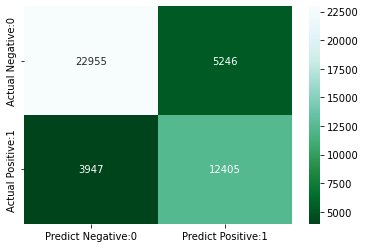

In [225]:
sns.heatmap(standard_tr, annot=True, fmt='d', cmap='BuGn_r')

In [226]:
standard_te=pd.DataFrame(data=cm_st, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

In [227]:
standard_te

,Predict Negative:0,Predict Positive:1
Actual Negative:0,5723,1313
Actual Positive:1,1002,3101


<AxesSubplot:>

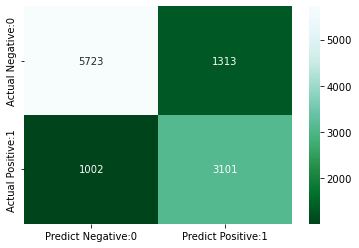

In [228]:
sns.heatmap(standard_te, annot=True, fmt='d', cmap='BuGn_r')

- Gridsearchcv결과

In [232]:
best_param=pd.DataFrame([best.best_params_,best_m.best_params_,best_l.best_params_],index=['best_standard','best_min-max','best_log'])

In [102]:
score=['정확도','정밀도','재현율','F1 score','ROC_AUC']

In [233]:
best_param

,C,gamma,kernel
best_standard,3,auto,rbf
best_min-max,50,scale,rbf
best_log,50,auto,rbf


#  결론 : Standard scaling이 가장 좋은 성능을 보임

In [243]:
y=[result_s.loc[5,'mean_test_score'],result_m.loc[5,'mean_test_score'],result_l.loc[5,'mean_test_score']]

In [244]:
x=['Standard','Min-Max','Log']

In [306]:
train_score

,정확도,정밀도,재현율,F1 score,ROC_AUC
Standard,0.793661,0.702793,0.758623,0.729642,0.786301
Min-Max,0.764348,0.658283,0.744313,0.698660,0.760139
Log,0.763203,0.652877,0.757644,0.701370,0.762036


In [144]:
standard_tr = pd.DataFrame(data=cm_s, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

In [256]:
y1=[base_st,base_m,base_l]

In [359]:
test_score.T

,Standard,Min-Max,Log
정확도,0.792172,0.765957,0.762815
정밀도,0.702537,0.662467,0.653887
재현율,0.755788,0.743359,0.756520
F1 score,0.728191,0.700586,0.701469
ROC_AUC,0.784588,0.761247,0.761503


In [364]:
test_score

,정확도,정밀도,재현율,F1 score,ROC_AUC
Standard,0.792172,0.702537,0.755788,0.728191,0.784588
Min-Max,0.765957,0.662467,0.743359,0.700586,0.761247
Log,0.762815,0.653887,0.756520,0.701469,0.761503


In [356]:
base_f

,정확도,정밀도,재현율,F1 score,ROC_AUC
base,0.735883,0.675113,0.545455,0.603397,0.696192
Standard,0.780643,0.683535,0.749205,0.714865,0.774039
Min-Max,0.742195,0.622274,0.757216,0.683145,0.745350
Log,0.751913,0.635351,0.760580,0.692348,0.753734


In [384]:
result=pd.concat([base_f,test_score],axis=0)

In [385]:
result

,정확도,정밀도,재현율,F1 score,ROC_AUC
base,0.735883,0.675113,0.545455,0.603397,0.696192
Standard,0.780643,0.683535,0.749205,0.714865,0.774039
Min-Max,0.742195,0.622274,0.757216,0.683145,0.745350
Log,0.751913,0.635351,0.760580,0.692348,0.753734
Standard(best),0.792172,0.702537,0.755788,0.728191,0.784588
Min-Max(best),0.765957,0.662467,0.743359,0.700586,0.761247
Log(best),0.762815,0.653887,0.756520,0.701469,0.761503


In [370]:
import matplotlib.pyplot as plt

In [389]:
# 한글 문제
# matplotlit의 기본 폰트에서 한글 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [390]:
def bar_graph(col_name):
    result[col_name].plot(kind='bar',color = '#4999B6')
    for i in range(0, 7):
        if result[col_name][i]==result[col_name].max():
            plt.text(i-0.25,result[col_name][i],round(result[col_name][i],3),color = 'red')

        else:
            plt.text(i-0.25,result[col_name][i],round(result[col_name][i],3))
    plt.xticks(rotation=70)
    plt.yticks(np.arange(0,1,0.3))
    plt.title('모델별'+col_name)

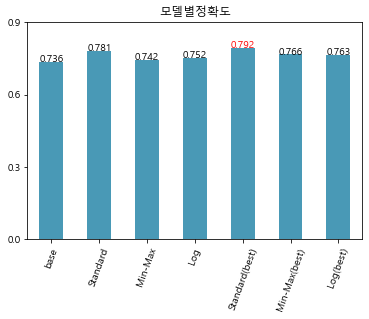

In [391]:
bar_graph('정확도')

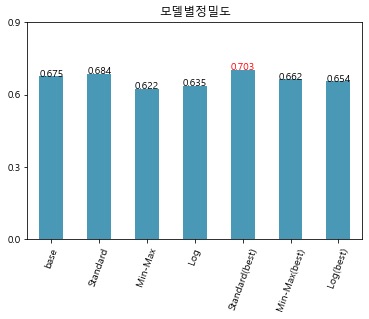

In [392]:
bar_graph('정밀도')

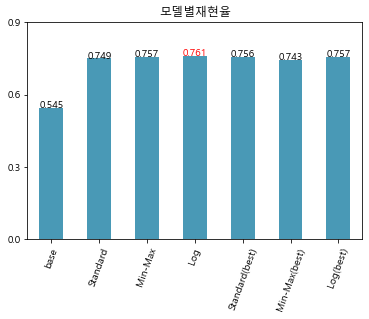

In [393]:
bar_graph('재현율')

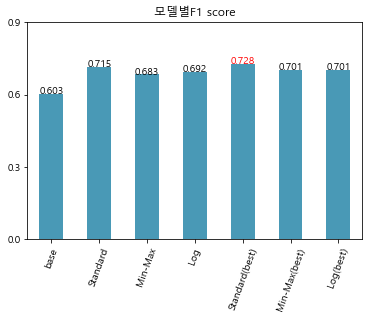

In [405]:
bar_graph('F1 score')

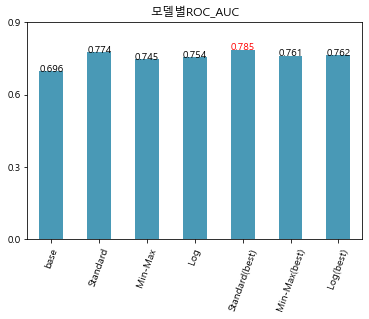

In [404]:
bar_graph('ROC_AUC')

In [ ]:
bar_graph('')

In [400]:
def bar_graph_model(num,num2,color):
    result.iloc[num].plot(kind='bar',color = color)
    for i in range(0, 5):
            plt.text(i-0.25,result.iloc[num][i],round(result.iloc[num][i],3))
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0,1,0.3))
    plt.title(result.index[num]+'&'+result.index[num2])
    plt.legend()

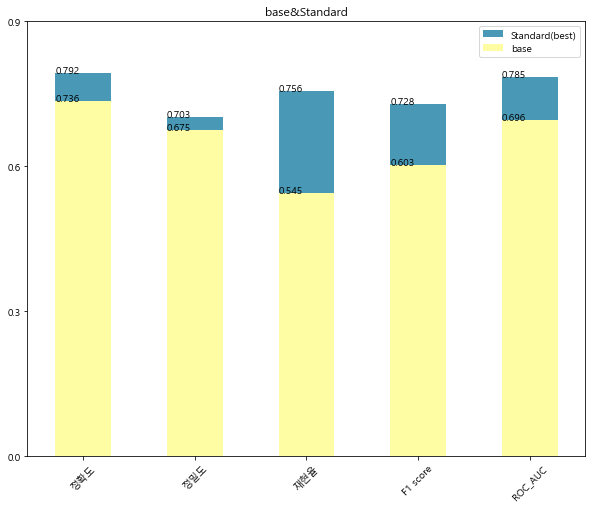

In [410]:
plt.figure(figsize=(10,8))
bar_graph_model(4,1,'#4999B6')
bar_graph_model(0,1,'#FEFDA3')

In [411]:
len(x_test_s)

11139

In [355]:
base_f=pd.DataFrame([exba,b1,b2,b3],index=['base','Standard','Min-Max','Log'],columns=['정확도','정밀도','재현율','F1 score','ROC_AUC'])

In [269]:
pd.DataFrame(evaluate,index=['Standard','Min-Max','Log'],columns=['accuracy'])

,accuracy
Standard,0.780643
Min-Max,0.742195
Log,0.751913


In [263]:
evaluate=[base_st,base_m,base_l]

In [329]:
SVM1=SVC()

In [330]:
base1=SVM1.fit(x_train_s,y_train_s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [331]:
pred_base1=base1.predict(x_train_s)

In [332]:
base_st=accuracy_score(y_train_s,pred_base1)

In [333]:
base_st

0.7806432787915516

In [334]:
test1=base1.predict(x_test_s)

In [335]:
confusion_matrix(y_test_s,test1)

array([[5617, 1419],
       [1015, 3088]], dtype=int64)

In [300]:
b1=score(y_train_s,pred_base1)

In [354]:
b1

(0.7806432787915516,
 0.6835351224683368,
 0.7492049902152642,
 0.7148650619985412,
 0.7740386853136532)

In [315]:
cm_b1=pd.DataFrame(data=confusion_matrix(pred_base1,y_train_s), columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

<AxesSubplot:>

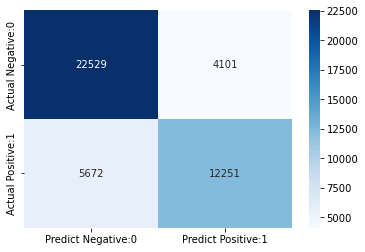

In [316]:
sns.heatmap(cm_b1, annot=True, fmt='d', cmap='Blues')

In [336]:
base2=SVM1.fit(x_train_m,y_train_m)

pred_base2=base2.predict(x_train_m)

base_m=accuracy_score(y_train_m,pred_base2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [337]:
base_m

0.7421946894709671

In [338]:
pr_m=base2.predict(x_test_m)
score(y_test_m,pr_m)

(0.7444115270670617,
 0.6267662494953573,
 0.7567633438947112,
 0.6856575024842664,
 0.746985992584081)

In [301]:
b2=score(y_train_m,pred_base2)
b2

(0.7421946894709671,
 0.6222735953362147,
 0.7572162426614482,
 0.683144827586207,
 0.7453504354330609)

In [317]:
cm_b2=pd.DataFrame(data=confusion_matrix(pred_base2,y_train_m), columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

<AxesSubplot:>

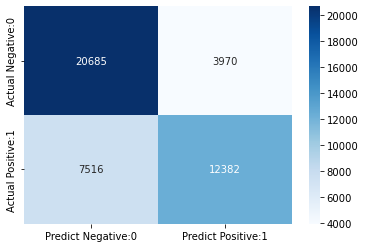

In [319]:
sns.heatmap(cm_b2, annot=True, fmt='d', cmap='Blues')

In [339]:
base3=SVM1.fit(x_train_l,y_train_l)

pred_base3=base3.predict(x_train_l)

base_l=accuracy_score(y_train_l,pred_base3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [340]:
base_l

0.7519134513949678

In [302]:
b3=score(y_train_l,pred_base3)
b3

(0.7519134513949678,
 0.6353512132822478,
 0.7605797455968689,
 0.6923483730898767,
 0.7537340769046719)

In [320]:
cm_b3=pd.DataFrame(data=confusion_matrix(pred_base3,y_train_m), columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

<AxesSubplot:>

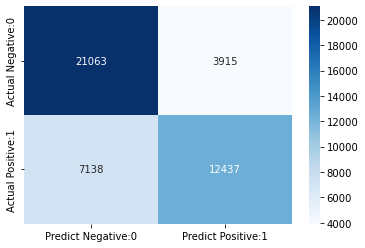

In [321]:
sns.heatmap(cm_b3, annot=True, fmt='d', cmap='Blues')